<a href="https://colab.research.google.com/github/junyeon-no/spam_app/blob/master/spammail_filter_using_LSTM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!pip install konlpy

In [53]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fd0ed0815c0>)

In [54]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')
print(len(train_data))
print(len(test_data))

150000
50000


In [56]:
data = pd.read_csv('./sample_data/spam_ko_utf8_csv_doc.csv',encoding='utf-8')
print(len(data))
train_data = data[:3310]
test_data = data[3310:]
print(len(train_data))
print(len(test_data))

4310
3310
1000


# 새 섹션

In [66]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 3310


In [67]:
train_data['label'] = train_data['label'].replace(['ham','spam'],[0,1])
test_data['label'] = test_data['label'].replace(['ham','spam'],[0,1])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [68]:
train_data[:5] # 상위 5개 출력

,label,document
0,1,"""[Web발신]\n[긴급재난자금] 상품권이 도착했습니다.\n확인해주세요."""
1,0,"주롱 지점까지 가세요, 미쳤어 요 .. 부기 스 앤 그레이트 월드 라 e 뷔페에서..."
2,1,무료 받아가세요 공짜 프리 확인
3,1,2 번의 무료 입장권은 FA 컵 결승전 tkts 2005 년 5 월 21 일 우승...
4,0,"U dun 말이 너무 이른 호 ... U c 벌써 ... ,,,"


In [69]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 1000


In [70]:
test_data[:5]

,label,document
3310,0,"난 여자들이 항상 안전하고 이기적인 걸 알아 감사합니다. 안녕히 주무세요.,,,"
3311,0,걱정 마세요. 화보 촬영이 잘 되셨으면 좋겠어요. 작업장에서 즐거운 시간 보내세요...
3312,0,"나는 얼고 얼음을 갈망하고 있습니다. Fml ,,,"
3313,0,"Kay ... 우리가 벌써 나가니까 ,,,"
3314,0,죄송합니다 레 ... 저는 메시지를 받았습니다. 이미 슬프지 않습니다. 지금 TV...


In [71]:
train_data['document'].nunique(), train_data['label'].nunique()
# train_data['v2'].nunique(), train_data['v1'].nunique()

(3126, 2)

In [72]:
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
# train_data.drop_duplicates(subset=['v2'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [73]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 3126


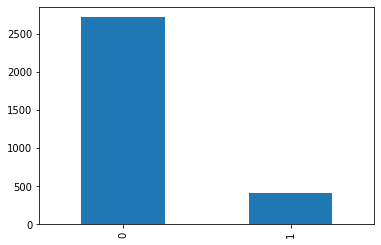

In [74]:
train_data['label'].value_counts().plot(kind = 'bar')

In [75]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   2718
1      1    408


In [76]:
print(train_data.isnull().values.any())

False


In [77]:
print(train_data.isnull().sum())

label       0
document    0
dtype: int64


In [78]:
train_data.loc[train_data.document.isnull()]

,label,document


In [79]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [80]:
print(len(train_data))

3126


In [81]:
text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
re.sub(r'[^a-zA-Z ]', '', text) #알파벳과 공백을 제외하고 모두 제거

'do you expect people to read the FAQ etc and actually accept hard atheism'

In [82]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,label,document
0,1,발신긴급재난자금 상품권이 도착했습니다확인해주세요
1,0,주롱 지점까지 가세요 미쳤어 요 부기 스 앤 그레이트 월드 라 뷔페에서만 사용...
2,1,무료 받아가세요 공짜 프리 확인
3,1,번의 무료 입장권은 컵 결승전 년 월 일 우승을 위해 무료로 입장합니다...
4,0,말이 너무 이른 호 벌써


In [84]:
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

label       0
document    0
dtype: int64


In [85]:
train_data.loc[train_data.document.isnull()][:5]

,label,document


In [86]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

3126


In [87]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 976


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [88]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [89]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [90]:
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [91]:
print(X_train[:3])

[['발신', '긴급', '재난', '자금', '상품권', '도착', '확인', '해주다'], ['주', '롱', '지점', '까지', '가세', '요', '미치다', '요', '부기', '스', '앤', '그레이', '트', '월드', '라', '뷔페', '에서만', '사용', '가능', '시', '네', '거기', '더', '많다', '와트'], ['무료', '받다', '공짜', '프리', '확인']]


In [92]:
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [93]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [94]:
print(tokenizer.word_index)

{'을': 1, '있다': 2, '당신': 3, '것': 4, '내': 5, '나': 6, '이다': 7, '수': 8, '로': 9, '에서': 10, '않다': 11, '그': 12, '보내다': 13, '없다': 14, '좋다': 15, '되다': 16, '에게': 17, '전화': 18, '말': 19, '우리': 20, '가다': 21, '늘다': 22, '지금': 23, '받다': 24, '요': 25, '그렇다': 26, '오다': 27, '보다': 28, '하고': 29, '어떻다': 30, '전화하다': 31, '알다': 32, '아니다': 33, '오늘': 34, '무료': 35, '그녀': 36, '시간': 37, '일': 38, '싶다': 39, '해': 40, '사람': 41, '고': 42, '사랑': 43, '개': 44, '때': 45, '생각': 46, '집': 47, '다': 48, '모든': 49, '메시지': 50, '더': 51, '만': 52, '시': 53, '나르다': 54, '위해': 55, '또는': 56, '난': 57, '알': 58, '같다': 59, '문자': 60, '말다': 61, '괜찮다': 62, '친구': 63, '네': 64, '저': 65, '너무': 66, '원하다': 67, '자다': 68, '많다': 69, '안녕하다': 70, '너': 71, '적': 72, '먹다': 73, '하지만': 74, '아직': 75, '번': 76, '주다': 77, '야': 78, '기다리다': 79, '해주다': 80, '그것': 81, '까지': 82, '모르다': 83, '이제': 84, '그리고': 85, '번호': 86, '밤': 87, '그래서': 88, '되어다': 89, '갈다': 90, '오': 91, '아': 92, '안': 93, '확인': 94, '안녕': 95, '대해': 96, '만나다': 97, '감사하다': 98, '그냥': 99, '얻다': 100, '분': 101, '여기':

In [95]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 4046
등장 빈도가 2번 이하인 희귀 단어의 수: 2468
단어 집합에서 희귀 단어의 비율: 60.99851705388038
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.459664451928036


In [96]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1580


In [97]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [98]:
print(X_train[:3])

[[345, 163, 1, 1, 745, 221, 95, 81], [130, 1, 1, 83, 1, 26, 459, 26, 1031, 424, 1, 1, 1258, 1, 460, 1, 1, 148, 1259, 54, 65, 149, 52, 70, 371], [36, 25, 1, 1, 95]]


In [99]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [100]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [101]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

3023
3023


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 172
리뷰의 평균 길이 : 10.903407211379424


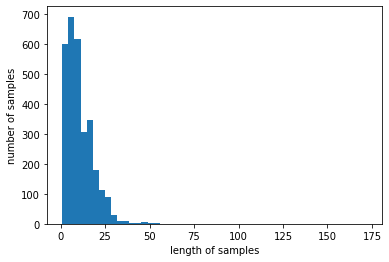

In [102]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [103]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [105]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 98.21369500496195


In [106]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [107]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [108]:
model = Sequential()
# model.add(Embedding(vocab_size, 100))
# model.add(LSTM(128))
model.add(Embedding(vocab_size, 32)) # 임베딩 벡터의 차원은 32
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))



In [109]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [110]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)
# history = model.fit(X_train, y_train, epochs=4, batch_size=64, validation_split=0.2)

Epoch 1/15
41/41 [==============================] - 2s 16ms/step - loss: 0.4829 - acc: 0.8558 - val_loss: 0.2337 - val_acc: 0.9025

Epoch 00001: val_acc improved from -inf to 0.90248, saving model to best_model.h5
Epoch 2/15
41/41 [==============================] - 0s 8ms/step - loss: 0.2270 - acc: 0.8983 - val_loss: 0.1754 - val_acc: 0.9405

Epoch 00002: val_acc improved from 0.90248 to 0.94050, saving model to best_model.h5
Epoch 3/15
41/41 [==============================] - 0s 8ms/step - loss: 0.1599 - acc: 0.9486 - val_loss: 0.1391 - val_acc: 0.9587

Epoch 00003: val_acc improved from 0.94050 to 0.95868, saving model to best_model.h5
Epoch 4/15
41/41 [==============================] - 0s 7ms/step - loss: 0.1095 - acc: 0.9718 - val_loss: 0.1745 - val_acc: 0.9603

Epoch 00004: val_acc improved from 0.95868 to 0.96033, saving model to best_model.h5
Epoch 5/15
41/41 [==============================] - 0s 7ms/step - loss: 0.0799 - acc: 0.9758 - val_loss: 0.1121 - val_acc: 0.9686

Epoch 0

In [111]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

31/31 [==============================] - 0s 3ms/step - loss: 0.1099 - acc: 0.9734

 테스트 정확도: 0.9734


In [129]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 스팸입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 스팸이 아닙니다.\n".format((1 - score) * 100))

In [130]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

99.54% 확률로 스팸이 아닙니다.



In [131]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

99.62% 확률로 스팸이 아닙니다.



In [132]:
sentiment_predict('존노잼')

98.94% 확률로 스팸이 아닙니다.



In [133]:
sentiment_predict('감독 뭐하는 놈이냐?')

99.71% 확률로 스팸이 아닙니다.



In [135]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

99.69% 확률로 스팸이 아닙니다.



In [134]:
sentiment_predict('''[Web발신]
[긴급재난자금] 상품권이 도착했습니다.
확인해주세요. https://bit.ly/3aSTMel''')

96.56% 확률로 스팸이 아닙니다.



In [136]:
sentiment_predict('광고가 아닙니다.')

99.18% 확률로 스팸이 아닙니다.

